# MCMC: Slice sampling

Florent Leclercq,<br/>
Institut d'Astrophysique de Paris,<br/>
florent.leclercq@iap.fr

In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm, cauchy
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
from cycler import cycler
np.random.seed(123456)

In [2]:
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': r"\usepackage{amsmath}\usepackage{upgreek}"})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 15})
dir="./plots/MCMC_Slice/"
!mkdir -p $dir

## One-dimensional slice sampling

### Slice sampling tutorial for a Gaussian distribution

In [3]:
gaussian=norm(0,1)
a=-5.
b=5.
x_arr=np.linspace(a,b,200)

#### 1- Drawing $y$

Starting from an initial $x$, we draw $y$ uniformly in $[0,f(x)]$.

In [4]:
x=1.3
f_of_x=gaussian.pdf(x)
y=np.random.uniform(0.,f_of_x)

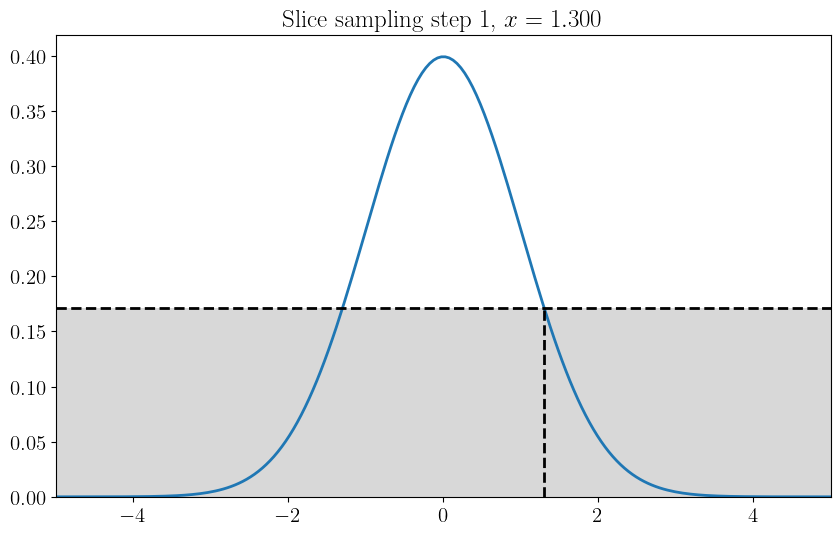

In [5]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlim([a,b])
ax.plot(x_arr,gaussian.pdf(x_arr))
ax.plot([x,x],[0.,f_of_x],color='black',linestyle='--')
ax.plot([a,b],[f_of_x,f_of_x],color='black',linestyle='--')
ax.fill_between([a,b],0.,f_of_x,facecolor='grey',alpha=0.3, linewidth=0.)
ax.set_ylim(bottom=0.)
ax.set_title("Slice sampling step 1, $x={:.3f}$".format(x))
plt.savefig(dir+'Slice_tutorial_1.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Slice_tutorial_1.png',dpi=300,bbox_inches="tight")
plt.show()

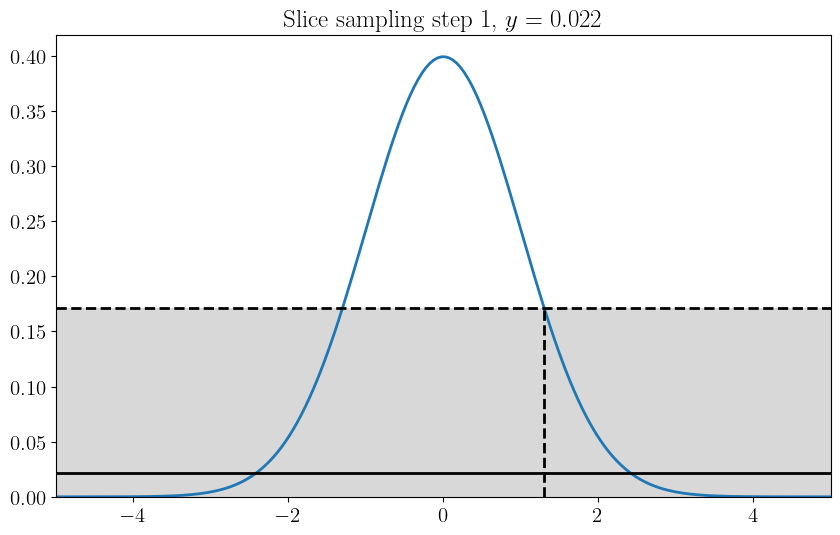

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlim([a,b])
ax.plot(x_arr,gaussian.pdf(x_arr))
ax.plot([x,x],[0.,f_of_x],color='black',linestyle='--')
ax.plot([a,b],[f_of_x,f_of_x],color='black',linestyle='--')
ax.plot([a,b],[y,y],color='black',linestyle='-')
ax.fill_between([a,b],0.,f_of_x,facecolor='grey',alpha=0.3, linewidth=0.)
ax.set_ylim(bottom=0.)
ax.set_title("Slice sampling step 1, $y={:.3f}$".format(y))
plt.savefig(dir+'Slice_tutorial_2.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Slice_tutorial_2.png',dpi=300,bbox_inches="tight")
plt.show()

#### 2- Drawing a new $x$

We draw $x$ uniformly in the "slice" where $f(x)\geq y$. In the case of the Gaussian distribution $G(0,1)$, this is drawing $x$ uniformly in $[-x_0,x_0]$ where $x_0=\sqrt{-2 \ln(y \sqrt{2\pi})}$. This proposed sample is always accepted (exact slice sampling is rejection-free).

In [7]:
x0=np.sqrt(-2*np.log(y*np.sqrt(2*np.pi)))
x_new=np.random.uniform(-x0,x0)

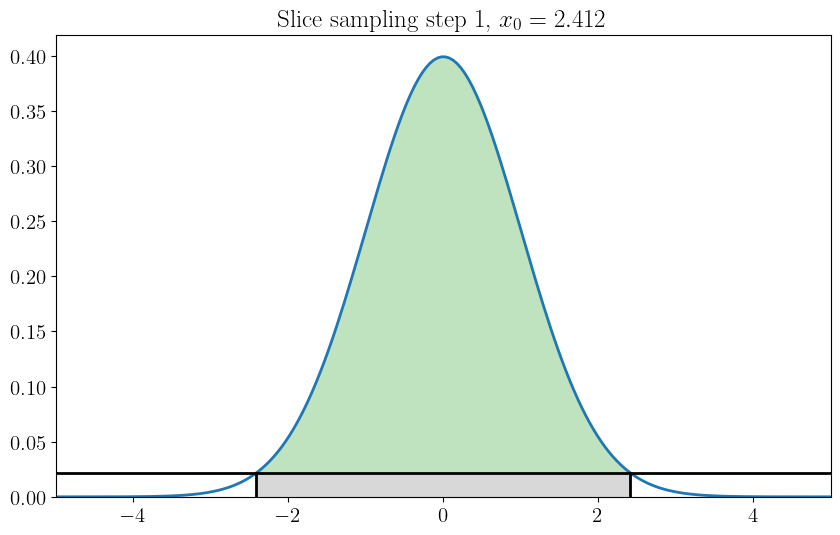

In [8]:
x_slice_arr = np.linspace(-x0,x0,100)
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlim([-5.,5.])
ax.plot(x_arr,gaussian.pdf(x_arr))
ax.plot([-5.,5.],[y,y],color='black')
ax.plot([x0,x0],[0.,y],color='black')
ax.plot([-x0,-x0],[0.,y],color='black')
ax.fill_between(x_slice_arr,0.,y,facecolor='grey',alpha=0.3, linewidth=0.)
ax.fill_between(x_slice_arr,y,gaussian.pdf(x_slice_arr),facecolor='C2',alpha=0.3, linewidth=0.)
ax.set_ylim(bottom=0.)
ax.set_title("Slice sampling step 1, $x_0={:.3f}$".format(x0))
plt.savefig(dir+'Slice_tutorial_3.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Slice_tutorial_3.png',dpi=300,bbox_inches="tight")
plt.show()

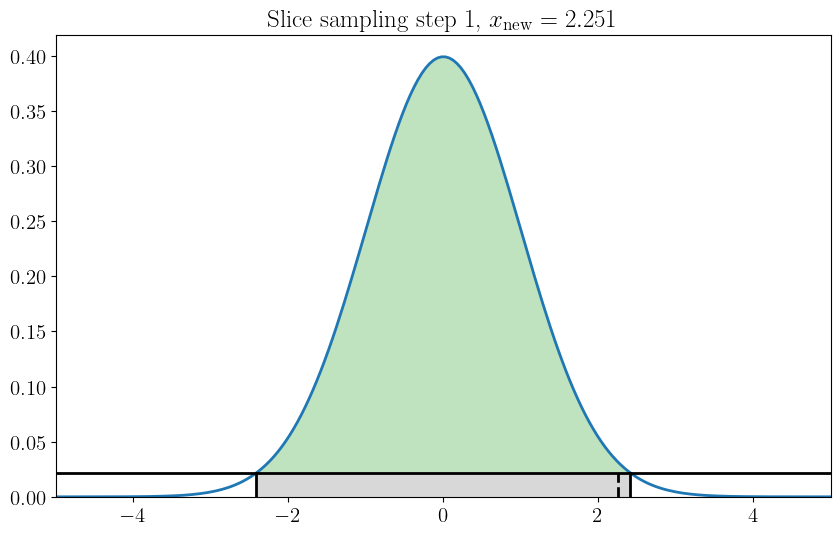

In [9]:
x_slice_arr = np.linspace(-x0,x0,100)
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlim([-5.,5.])
ax.plot(x_arr,gaussian.pdf(x_arr))
ax.plot([-5.,5.],[y,y],color='black')
ax.plot([x0,x0],[0.,y],color='black')
ax.plot([-x0,-x0],[0.,y],color='black')
ax.plot([x_new,x_new],[0.,y],color='black',linestyle='--')
ax.fill_between(x_slice_arr,0.,y,facecolor='grey',alpha=0.3, linewidth=0.)
ax.fill_between(x_slice_arr,y,gaussian.pdf(x_slice_arr),facecolor='C2',alpha=0.3, linewidth=0.)
ax.set_ylim(bottom=0.)
ax.set_title("Slice sampling step 1, $x_\\mathrm{{new}}={:.3f}$".format(x_new))
plt.savefig(dir+'Slice_tutorial_4.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Slice_tutorial_4.png',dpi=300,bbox_inches="tight")
plt.show()

#### 3- Iterate!

In [10]:
# MCMC version: each sample depends on previous sample (Markov Chain)
def slice_sampler_gaussian_MCMC(Nsamp, x_start):
    samples = np.zeros(Nsamp)
    samples[0] = x_start  # Initialize chain
    x = x_start           # Current position
    for i in range(Nsamp-1):
        # Step 1: Compute pdf at current position and sample a "height" y uniformly from 0 up to f(x)
        f_of_x = gaussian.pdf(x)
        y = np.random.uniform(0., f_of_x)
        # Step 2: Invert to find slice boundaries for this y and sample new x uniformly within current slice
        x0 = np.sqrt(-2 * np.log(y * np.sqrt(2 * np.pi)))
        x = np.random.uniform(-x0, x0)
        samples[i] = x   # Save new sample
    return samples

# Using the analytic solution for the Gaussian pdf, we can even write
# a version where each sample is independent of the others.
# This is not a Markov Chain, but a simple random sampling from the
# Gaussian distribution. This is not the typical use of slice sampling,
# but it serves to illustrate the difference between the two methods.
def slice_sampler_gaussian_iid(Nsamp):
    samples = np.zeros(Nsamp)
    max_height = 1.0 / np.sqrt(2 * np.pi)  # Maximum value of standard normal pdf
    for i in range(Nsamp-1):
        # Step 1: Sample a "height" y uniformly from under the pdf curve
        y = np.random.uniform(0, max_height)
        # Step 2: Invert to find slice boundaries for this y and sample new x uniformly within current slice
        x0 = np.sqrt(-2 * np.log(y * np.sqrt(2 * np.pi)))
        x = np.random.uniform(-x0, x0)
        samples[i] = x  # Save the sample
    return samples

In [11]:
x_start=2.
Nsamp=50
samples_MCMC=slice_sampler_gaussian_MCMC(Nsamp,x_start)
samples_iid=slice_sampler_gaussian_iid(Nsamp)

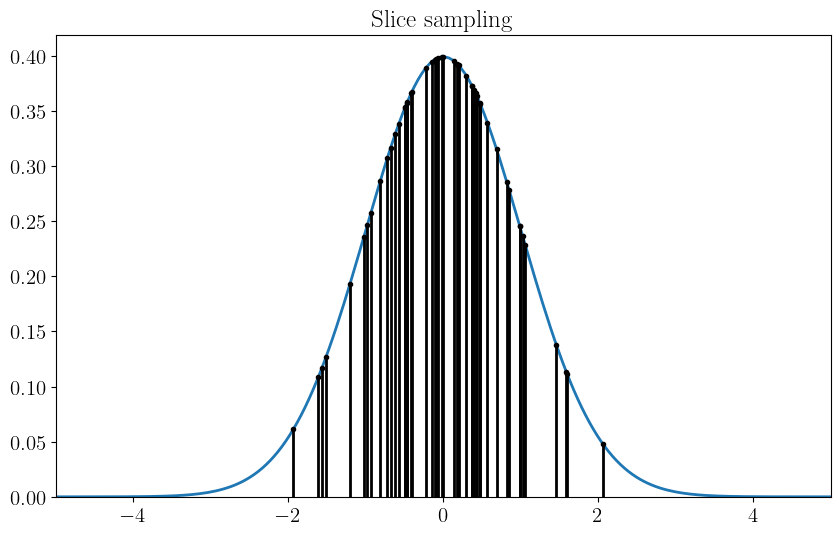

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlim([-5.,5.])
ax.plot(x_arr,gaussian.pdf(x_arr))
markerline, stemlines, baseline = plt.stem(samples_MCMC,gaussian.pdf(samples_MCMC),linefmt='-k',markerfmt='k.')
baseline.set_visible(False)
ax.set_title("Slice sampling")
ax.set_ylim(bottom=0.)
plt.savefig(dir+'Slice_tutorial_samples.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Slice_tutorial_samples.png',dpi=300,bbox_inches="tight")
plt.show()

#### Animated gif

In [13]:
def slice_sampler_gaussian_gif(Nsamp, x_start, gif_filename=dir+"Slice_tutorial.gif"):
    import imageio.v2 as imageio
    import os.path

    # Plotting limits
    a, b = -5, 5
    x_arr = np.linspace(a, b, 500)
    samples = np.zeros(Nsamp)
    samples[0] = x_start  # Initialize chain
    x = x_start           # Current position

    # Create a folder for temp frames
    frames_folder = dir
    frame_files = []

    for i in range(1, Nsamp):
        # Step 1: Compute pdf at current position, sample "height" y
        f_of_x = gaussian.pdf(x)
        y = np.random.uniform(0., f_of_x)

        # ===== Plot 1: Current location, pdf, and maximum height =====
        fig, ax = plt.subplots(figsize=(10,6))
        ax.set_xlim([a,b])
        ax.plot(x_arr,gaussian.pdf(x_arr))
        ax.plot([x,x],[0.,f_of_x],color='black',linestyle='--')
        ax.plot([a,b],[f_of_x,f_of_x],color='black',linestyle='--')
        ax.fill_between([a,b],0.,f_of_x,facecolor='grey',alpha=0.3, linewidth=0.)
        ax.set_ylim(bottom=0.)
        ax.set_title("Slice sampling step {:d}, $x={:.3f}$".format(i, x))

        frame_path1 = os.path.join(frames_folder, f"frame_{4*i-4:03d}.png")
        fig.savefig(frame_path1, bbox_inches='tight')
        plt.close(fig)
        frame_files.append(frame_path1)

        # ===== Plot 2: Current location, pdf, and chosen height =====
        fig, ax = plt.subplots(figsize=(10,6))
        ax.set_xlim([a,b])
        ax.plot(x_arr,gaussian.pdf(x_arr))
        ax.plot([x,x],[0.,f_of_x],color='black',linestyle='--')
        ax.plot([a,b],[f_of_x,f_of_x],color='black',linestyle='--')
        ax.plot([a,b],[y,y],color='black',linestyle='-')
        ax.fill_between([a,b],0.,f_of_x,facecolor='grey',alpha=0.3, linewidth=0.)
        ax.set_ylim(bottom=0.)
        ax.set_title("Slice sampling step {:d}, $y={:.3f}$".format(i, y))

        frame_path2 = os.path.join(frames_folder, f"frame_{4*i-3:03d}.png")
        fig.savefig(frame_path2, bbox_inches='tight')
        plt.close(fig)
        frame_files.append(frame_path2)

        # Step 2: Invert to find slice boundaries for this y, sample new x
        x0 = np.sqrt(-2 * np.log(y * np.sqrt(2 * np.pi)))
        x_new = np.random.uniform(-x0, x0)

        # ===== Plot 3: The "slice" interval =====
        x_slice_arr = np.linspace(-x0,x0,100)
        fig, ax = plt.subplots(figsize=(10,6))
        ax.set_xlim([-5.,5.])
        ax.plot(x_arr,gaussian.pdf(x_arr))
        ax.plot([-5.,5.],[y,y],color='black')
        ax.plot([x0,x0],[0.,y],color='black')
        ax.plot([-x0,-x0],[0.,y],color='black')
        # ax.plot([x_new,x_new],[0.,y],color='black',linestyle='--')
        ax.fill_between(x_slice_arr,0.,y,facecolor='grey',alpha=0.3, linewidth=0.)
        ax.fill_between(x_slice_arr,y,gaussian.pdf(x_slice_arr),facecolor='C2',alpha=0.3, linewidth=0.)
        ax.set_ylim(bottom=0.)
        ax.set_title("Slice sampling step {:d}, $x_0={:.3f}$".format(i, x0))

        frame_path3 = os.path.join(frames_folder, f"frame_{4*i-2:03d}.png")
        fig.savefig(frame_path3, bbox_inches='tight')
        plt.close(fig)
        frame_files.append(frame_path3)

        # ===== Plot 3: The "slice" interval and the new x sample =====
        fig, ax = plt.subplots(figsize=(10,6))
        ax.set_xlim([-5.,5.])
        ax.plot(x_arr,gaussian.pdf(x_arr))
        ax.plot([-5.,5.],[y,y],color='black')
        ax.plot([x0,x0],[0.,y],color='black')
        ax.plot([-x0,-x0],[0.,y],color='black')
        ax.plot([x_new,x_new],[0.,y],color='black',linestyle='--')
        ax.fill_between(x_slice_arr,0.,y,facecolor='grey',alpha=0.3, linewidth=0.)
        ax.fill_between(x_slice_arr,y,gaussian.pdf(x_slice_arr),facecolor='C2',alpha=0.3, linewidth=0.)
        ax.set_ylim(bottom=0.)
        ax.set_title("Slice sampling step {:d}, $x_\\mathrm{{new}}={:.3f}$".format(i, x_new))

        frame_path4 = os.path.join(frames_folder, f"frame_{4*i-1:03d}.png")
        fig.savefig(frame_path4, bbox_inches='tight')
        plt.close(fig)
        frame_files.append(frame_path4)

        samples[i] = x_new
        x = x_new

    # Make animated gif!
    with imageio.get_writer(gif_filename, mode='I', duration=1000, loop=0) as writer:
        for filename in frame_files:
            image = imageio.imread(filename)
            writer.append_data(image)
    print(f"Animated GIF saved as {gif_filename}")

    # Clean up: delete temp files at the end
    for f in frame_files:
        os.remove(f)

    return samples

In [14]:
x_start=2.
Nsamp=10
samples_MCMC=slice_sampler_gaussian_gif(Nsamp,x_start)

Animated GIF saved as ./plots/MCMC_Slice/Slice_tutorial.gif


#### Different chains and their auto-correlation

In [15]:
# Run Nchains different chains starting at different positions in parameter space
Nsamp = 50
Nchains = 5
chains = [slice_sampler_gaussian_MCMC(Nsamp,x_start)
          for x_start in np.linspace(-4,4,Nchains)]
chains = np.array(chains)

In [16]:
# Based on python code from the emcee tutorials, https://emcee.readthedocs.io/en/stable/tutorials/autocorr/

def next_power_of_2(n: int) -> int:
    """Smallest power of two ≥ n."""
    return 1 << (n - 1).bit_length() if n > 0 else 1

# 1D autocorrelation function
def autocorr_func_1d(x, norm=True):
    """
    Compute the 1D autocorrelation via FFT in O(N log N).
    If norm=True, normalize so acf[0] = 1.
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    nfft = 2 * next_power_of_2(n)

    # real FFT
    f = np.fft.rfft(x - np.mean(x), n=nfft)
    ps = (f * f.conjugate()).real      # power spectrum
    acf = np.fft.irfft(ps, n=nfft)[:n]
    acf /= 2 * nfft

    # normalise
    if norm:
        if acf[0] <= 0:
            return 0 # or raise ValueError("Autocorrelation function is zero or negative at lag 0.")
        else:
            acf /= acf[0]
    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    """
    Return the first lag k for which k < c * tau_k fails.
    If none fail, return len(taus)-1.
    """
    k = np.arange(len(taus))
    mask = k < c * taus
    # find first index where mask is False
    idx = np.argmax(~mask)
    return idx if mask[idx] == False else len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(x, c: float = 5.0) -> float:
    """
    Estimate the integrated autocorrelation time following
    Goodman & Weare (2010), with window parameter c.
    """
    acf = autocorr_func_1d(x, norm=True)
    taus = 2.0 * np.cumsum(acf) - 1.0
    window = auto_window(taus, c)
    return taus[window]

def N_eff(x) -> float:
    """
    Effective number of independent samples in x.
    Accepts input as either a list or a 1D numpy array.
    """
    x = np.asarray(x)
    tau = autocorr_gw2010(x)
    if tau <= 0:
        return 0 # or raise ValueError("Autocorrelation time is zero or negative.")
    return x.size / tau

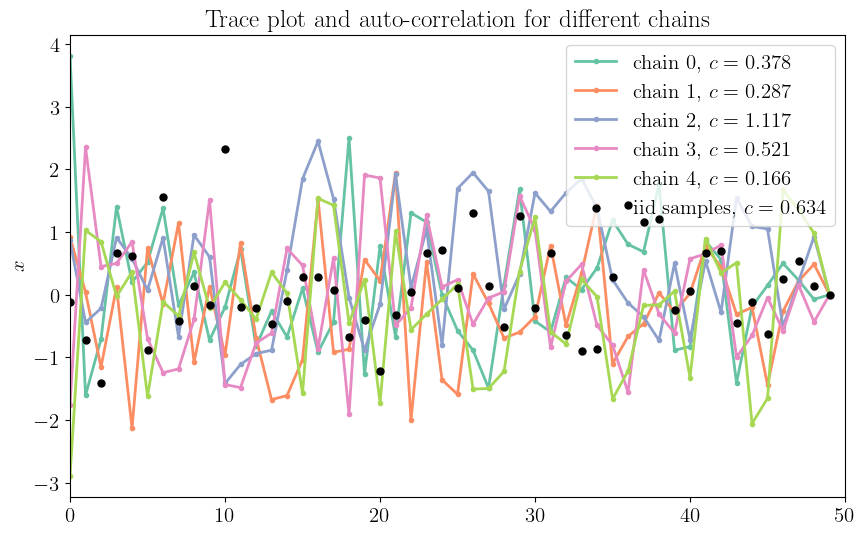

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.set_prop_cycle(cycler('color', [plt.cm.Set2(i) for i in np.linspace(0, 1, 8)]))
ax.set_xlim([0,Nsamp])
ax.set_ylabel("$x$")
ax.set_title("Trace plot and auto-correlation for different chains")
for c in range(Nchains):
    ax.plot(np.arange(Nsamp),chains[c],marker='.',label='chain {:d}, $c={:.3f}$'.format(c,autocorr_gw2010(chains[c,:])))
ax.scatter(np.arange(Nsamp),samples_iid,marker='.',s=100,color='black',zorder=10,label='iid samples, $c={:.3f}$'.format(autocorr_gw2010(samples_iid)))
plt.legend(loc="best")
plt.savefig(dir+'Slice_tutorial_trace_plot.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Slice_tutorial_trace_plot.png',dpi=300,bbox_inches="tight")
plt.show()

### Slice sampling in practice and multimodal distributions

In [18]:
cauchy_dist = cauchy(loc=0.8, scale=0.5)
norm_dist = norm(loc=2.8, scale=0.3)

def target_pdf(x):
    return cauchy_dist.pdf(x) + 0.5 * norm_dist.pdf(x)

In [19]:
a=-2.
b=5.
x_arr=np.linspace(a,b,400)
f_arr=target_pdf(x_arr)

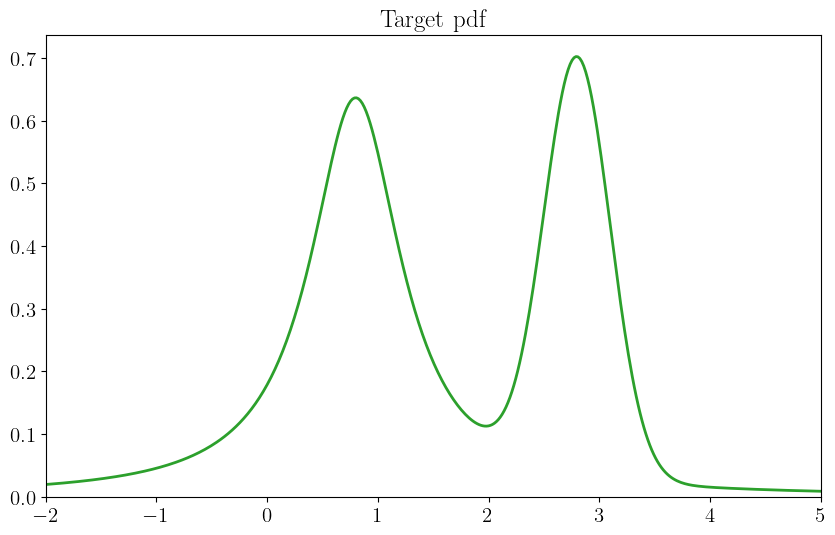

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlim([a,b])
ax.plot(x_arr,f_arr,color='C2')
ax.set_title("Target pdf")
ax.set_ylim(bottom=0.)
plt.savefig(dir+'Slice_1D_target_pdf.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Slice_1D_target_pdf.png',dpi=300,bbox_inches="tight")
plt.show()

In our implementation of the slice sampler, we make use of the "stepping out" and "shrinkage" procedures as described in Radford Neal's 2000 paper, *"Slice Sampling"* ([arXiv:physics/0009028](https://arxiv.org/abs/physics/0009028)).

**Stepping Out:**  
This technique is used to find a sufficiently wide interval containing the current "slice" — the set of points where the density is above a randomly chosen threshold. Starting from the current position, the algorithm expands the interval in both directions in steps of a chosen width until both ends fall outside the slice (or until a maximum number of steps is reached).

**Shrinkage:**  
Once the interval is identified, we repeatedly propose new points uniformly within this interval. If a proposal is outside the "slice," we shrink the interval to exclude this proposal, and repeat, until an acceptable sample is found. This ensures that proposed samples are uniformly distributed along the slice.

These two techniques guarantee robust exploration of the 1D target distribution, even when it is multimodal or has complex shapes.

In [21]:
def slice_sampler(target_pdf, Nsamp, x_start, w=1.0, m=10):
    samples = np.zeros(Nsamp)
    x = x_start

    for i in range(Nsamp-1):
        # Sample y ~ Uniform(0, f(x))
        fx = target_pdf(x)
        y = np.random.uniform(0, fx)

        # STEPPING OUT
        # Propose initial interval [L, R]
        u = np.random.uniform()
        L = x - w * u
        R = L + w
        # Step out to left
        steps_left = 0
        while target_pdf(L) > y and steps_left < m:
            L -= w
            steps_left += 1
        # Step out to right
        steps_right = 0
        while target_pdf(R) > y and steps_right < m:
            R += w
            steps_right += 1

        # SHRINKAGE: sample candidate within [L, R], shrink until accepted
        while True:
            x_proposal = np.random.uniform(L, R)
            if target_pdf(x_proposal) >= y:
                x = x_proposal
                break
            else:
                # Shrink the interval
                if x_proposal < x:
                    L = x_proposal
                else:
                    R = x_proposal

        samples[i] = x

    return samples

In [22]:
x_width=0.5 # a good width to explore the multimodal distribution
Nsamp=100
x_start=3.2
samples=slice_sampler(target_pdf,Nsamp,x_start,x_width)

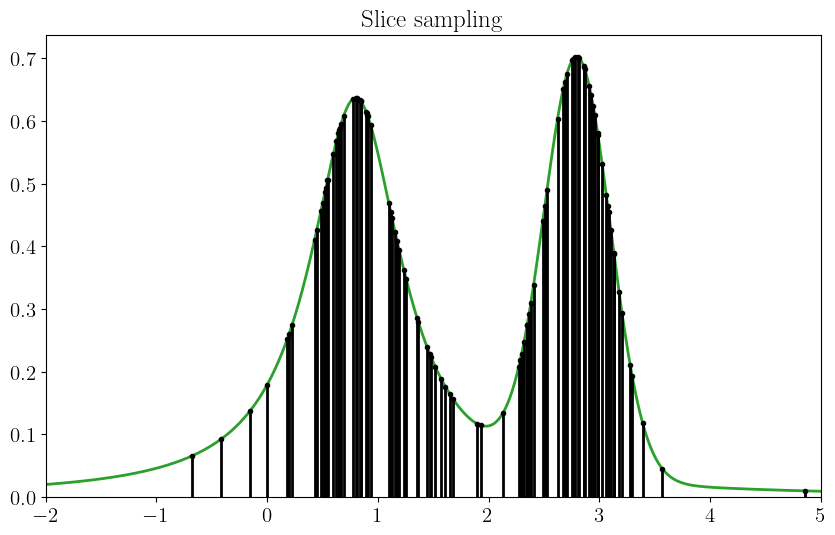

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlim([a,b])
ax.plot(x_arr,f_arr,color='C2')
ax.set_title("Slice sampling")
markerline, stemlines, baseline = plt.stem(samples,target_pdf(samples),linefmt='-k',markerfmt='k.')
baseline.set_visible(False)
ax.set_ylim(bottom=0.)
plt.savefig(dir+'Slice_1D_target_pdf_and_samples.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Slice_1D_target_pdf_and_samples.png',dpi=300,bbox_inches="tight")
plt.show()

In [24]:
Nsamp=200
x_start=3.2
w1, m1 = 0.1, 10
samples_m1=slice_sampler(target_pdf,Nsamp,x_start,w=w1,m=m1)
w2, m2 = 0.5, 10
samples_m2=slice_sampler(target_pdf,Nsamp,x_start,w=w2,m=m2)
w3, m3 = 0.5, 100
samples_m3=slice_sampler(target_pdf,Nsamp,x_start,w=w3,m=m3)

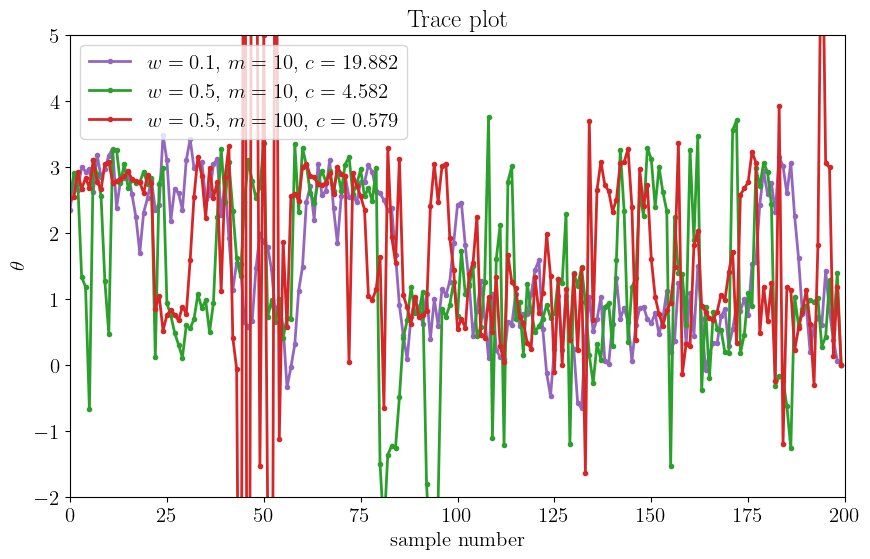

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlim(0,Nsamp)
ax.set_ylim(a,b)
ax.set_xlabel("sample number")
ax.set_ylabel("$\\theta$")
ax.set_title("Trace plot")
ax.plot(np.arange(Nsamp),samples_m1,marker='.',color='C4',label='$w={:.1f}$, $m={:d}$, $c={:.3f}$'.format(w1,m1,autocorr_gw2010(samples_m1)))
ax.plot(np.arange(Nsamp),samples_m2,marker='.',color='C2',label='$w={:.1f}$, $m={:d}$, $c={:.3f}$'.format(w2,m2,autocorr_gw2010(samples_m2)))
ax.plot(np.arange(Nsamp),samples_m3,marker='.',color='C3',label='$w={:.1f}$, $m={:d}$, $c={:.3f}$'.format(w3,m3,autocorr_gw2010(samples_m3)))
plt.legend(loc="best")
plt.savefig(dir+'Slice_1D_trace_plot.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Slice_1D_trace_plot.png',dpi=300,bbox_inches="tight")
plt.show()

## Two-dimensional slice sampling

### The target pdf

In [26]:
def target_joint(x,y):
    return x*x * np.exp(-x*y*y -y*y +2.*y -4.*x)
def target_logjoint(x, y):
    return np.where(x>1e-10, 2.*np.log(np.fabs(x)) -x*y*y - y*y + 2.*y - 4.*x, -1e8)
def target_marginal_x(x):
    return x*x/np.sqrt(x+1) * np.exp(-4.*x -1./(x+1.))
def target_marginal_y(y):
    return np.exp(-y*y+2.*y) / (y*y+4.)**3

In [27]:
# Normalization of the marginals
Nx=quad(target_marginal_x,0.0001,100.)[0]
Ny=quad(target_marginal_y,-100.,100.)[0]

In [28]:
xmin=0.
xmax=2.
ymin=-1.
ymax=2.5
x=np.linspace(xmin,xmax,1000)
y=np.linspace(ymin,ymax,1000)
X,Y=np.meshgrid(x,y)
Z=target_joint(X,Y)

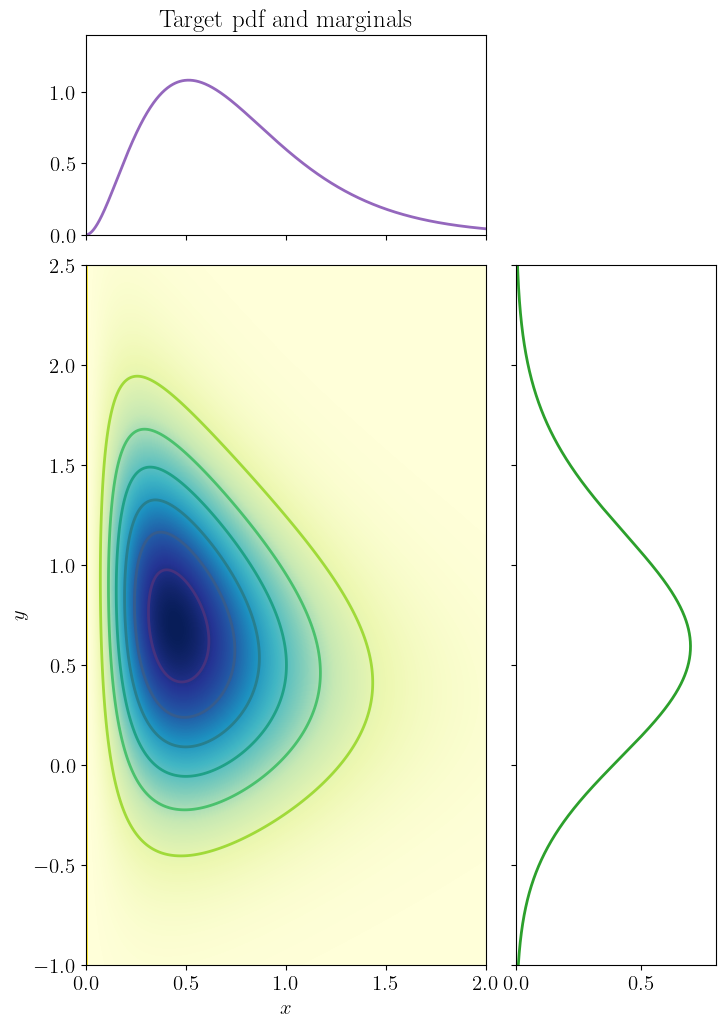

In [29]:
nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0., xmax-xmin
bottom, height = 0., ymax-ymin
left_h = left + width + 0.15
bottom_h = bottom + height + 0.15

rect_pdf = [left, bottom, width, height]
rect_pdfx = [left, bottom_h, width, 1.]
rect_pdfy = [left_h, bottom, 1., height]

# start with a rectangular Figure
plt.figure(1, figsize=(2, 2))

ax = plt.axes(rect_pdf)
axpdfx = plt.axes(rect_pdfx)
axpdfy = plt.axes(rect_pdfy)

# no labels
axpdfx.xaxis.set_major_formatter(nullfmt)
axpdfy.yaxis.set_major_formatter(nullfmt)

# the 2D plot:
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.imshow(Z,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='YlGnBu')
ax.contour(X,Y,Z,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='viridis_r')

# the marginals:
axpdfx.set_xlim(xmin,xmax)
axpdfx.set_ylim([0,1.4])
axpdfx.plot(x,target_marginal_x(x)/Nx,color='C4')

axpdfy.set_xlim([0,0.8])
axpdfy.set_ylim(ymin,ymax)
axpdfy.plot(target_marginal_y(y)/Ny,y,color='C2')

axpdfx.set_title("Target pdf and marginals")
plt.savefig(dir+'Slice_2D_target_pdf.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Slice_2D_target_pdf.png',dpi=300,bbox_inches="tight")
plt.show()

### The sampler

In [30]:
import numpy as np

def slice_sampler_1D(logf, x0, w=1.0, m=100, args=()):
    """1D slice sampler for conditional sampling, using logpdf."""
    x = x0
    logfx = logf(x, *args)
    log_y = logfx + np.log(np.random.uniform())

    # Stepping out
    u = np.random.uniform()
    L = x - w * u
    R = L + w
    # Expand left
    steps = 0
    while logf(L, *args) > log_y and steps < m:
        L -= w
        steps += 1
    # Expand right
    steps = 0
    while logf(R, *args) > log_y and steps < m:
        R += w
        steps += 1

    # Shrinkage
    while True:
        x_new = np.random.uniform(L, R)
        if logf(x_new, *args) >= log_y:
            return x_new
        elif x_new < x:
            L = x_new
        else:
            R = x_new

def slice_sampler_2D(target_logpdf, Nsamp, x_start, y_start, wx=1.0, wy=1.0, m=100):
    """
    2D slice sampler with stepping out and shrinkage, using logpdf.
    Args:
        target_logpdf: callable, logPDF function of (x, y)
        Nsamp: int, number of samples
        x_start, y_start: starting points
        wx, wy: initial stepping width for x and y
        m: max steps for stepping out
    Returns:
        samples: array, shape (Nsamp, 2)
    """
    samples = np.zeros((Nsamp, 2))
    x, y = x_start, y_start
    for i in range(Nsamp):
        # x | y
        def logfx(x_val, y_val=y):
            return target_logpdf(x_val, y_val)
        x = slice_sampler_1D(logfx, x, w=wx, m=m)
        # y | x
        def logfy(y_val, x_val=x):
            return target_logpdf(x_val, y_val)
        y = slice_sampler_1D(logfy, y, w=wy, m=m)
        samples[i, 0] = x
        samples[i, 1] = y
    return samples

In [31]:
Nsamp=2000
x_start=1.8
y_start=1.4
samples=slice_sampler_2D(target_logjoint,Nsamp,x_start,y_start)

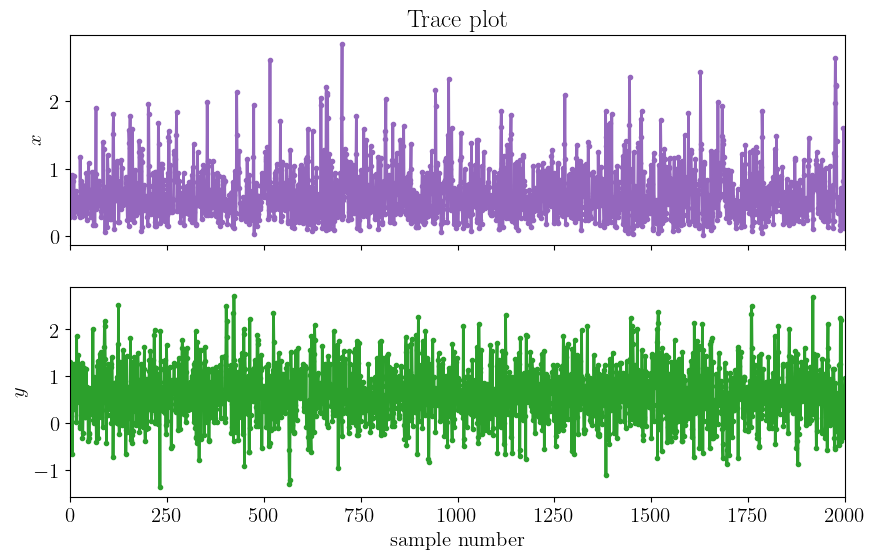

In [32]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,6), sharex=True)
ax0.set_ylabel("$x$")
ax0.set_title("Trace plot")
ax0.plot(np.arange(Nsamp),samples.T[0],marker='.',color='C4')
ax1.set_xlim([0,Nsamp])
ax1.set_xlabel("sample number")
ax1.set_ylabel("$y$")
ax1.plot(np.arange(Nsamp),samples.T[1],marker='.',color='C2')
plt.savefig(dir+'Slice_2D_trace_plot.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Slice_2D_trace_plot.png',dpi=300,bbox_inches="tight")
plt.show()

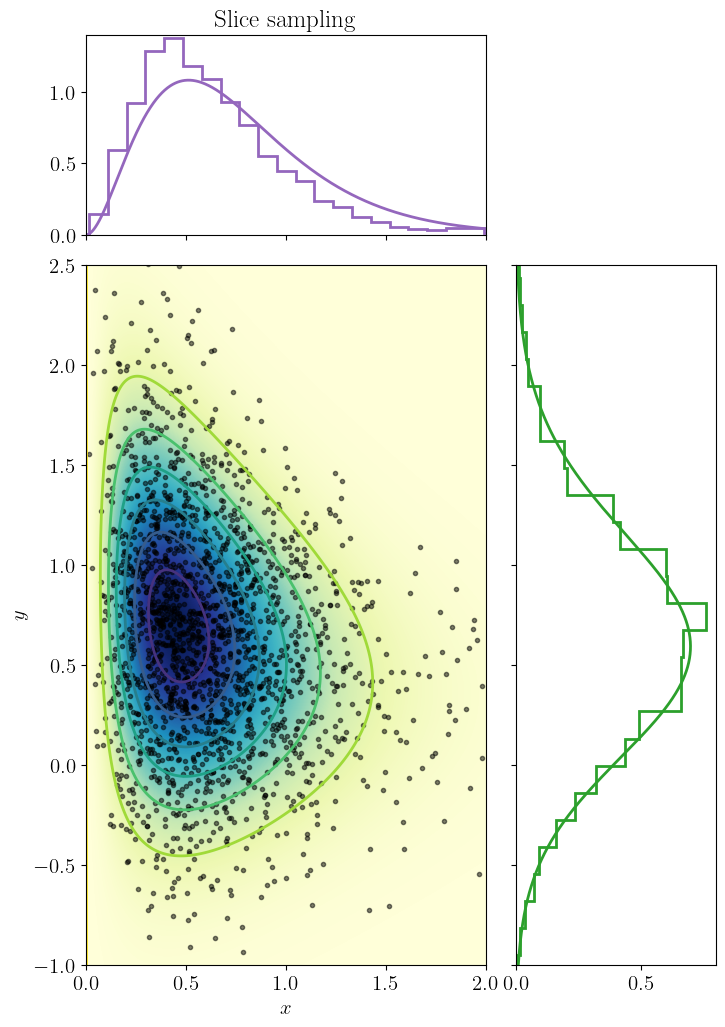

In [33]:
nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0., xmax-xmin
bottom, height = 0., ymax-ymin
left_h = left + width + 0.15
bottom_h = bottom + height + 0.15

rect_pdf = [left, bottom, width, height]
rect_pdfx = [left, bottom_h, width, 1.]
rect_pdfy = [left_h, bottom, 1., height]

# start with a rectangular Figure
plt.figure(1, figsize=(2, 2))

ax = plt.axes(rect_pdf)
axpdfx = plt.axes(rect_pdfx)
axpdfy = plt.axes(rect_pdfy)

# no labels
axpdfx.xaxis.set_major_formatter(nullfmt)
axpdfy.yaxis.set_major_formatter(nullfmt)

# the 2D plot:
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.imshow(Z,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='YlGnBu')
ax.contour(X,Y,Z,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='viridis_r')
ax.scatter(samples.T[0], samples.T[1], marker='.', color='black', alpha=0.5)

# the marginals:
axpdfx.set_xlim(xmin,xmax)
axpdfx.set_ylim([0,1.4])
axpdfx.plot(x,target_marginal_x(x)/Nx,color='C4')
axpdfx.hist(samples.T[0],30,density=True,histtype='step',color='C4',linewidth=2.)

axpdfy.set_xlim([0,0.8])
axpdfy.set_ylim(ymin,ymax)
axpdfy.plot(target_marginal_y(y)/Ny,y,color='C2')
axpdfy.hist(samples.T[1],30,density=True,histtype='step',color='C2',linewidth=2.,orientation='horizontal')

axpdfx.set_title("Slice sampling")
plt.savefig(dir+'Slice_2D_target_pdf_and_samples.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'Slice_2D_target_pdf_and_samples.png',dpi=300,bbox_inches="tight")
plt.show()